In [65]:
#this is pretty messy, I intend to go through and cleanup / annotate soon
#This code is built from the example found here: http://dan.iel.fm/emcee/current/user/line/#results

import numpy as np
import emcee
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import functions as f
%matplotlib inline
filename     = 'DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV

for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break

mass_ratio = 0.898896068135
Period = 15.8045

#this function is a slighty tweaked version of the plotter function, designed to play nicely with
#scipy's curvefit function. Used for an initial estimate of the parameters, from the primary data
def alteredRV(x, K, e, w, T, P, y): #function generates RV values plot from given parameters
    M = (2*np.pi/P)*(x-T) #Mean Anomaly is a function of time
    E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
    while True: #iteratively refines estimate of E1 from initial estimate
        E0 = E1
        M0 = E0 - e*np.sin(E0)
        E1 = E0 +(M-M0)/(1-e*np.cos(E0))
        if np.amax(E1-E0) < 1E-9:
            break
    nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
    p = ((K)*(np.cos(nu+w) + (e*np.cos(w)))+y)
    return p

initial_guess, cov = curve_fit(alteredRV, JDp, np.asarray(RVp),
                            bounds=([0, 0, 0, JD[0], 15, 10], [200, 0.9, 2*np.pi, JD[-1], 16.6, 35]))

def likelihood(mass_ratio, primary, secondary, parameters):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

def constraints(parameters):
    K, e, w, T, P, y = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5]
    if  0 < K < 200 and 0 < e < 0.9 and 0 < w < 2*np.pi and JD[0] < T < JD[-1] and 15 < P < 16.6 and 10 < y < 35:
        return 0
    return -np.inf

def probability(mass_ratio, RVp, RVs, initial_guess):
    con = constraints(initial_guess)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(mass_ratio, RVp, RVs, initial_guess)

ndim, nwalkers = 6, 2000
pos = [initial_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(mass_ratio, RVp, RVs))
sampler.run_mcmc(pos, 5000)

/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


(array([[  2.12061987e+01,   5.76449392e-01,   4.05956240e+00,
           5.13207998e+04,   1.58009615e+01,   2.36798504e+01],
        [  2.12063157e+01,   5.76426266e-01,   4.05943312e+00,
           5.13207999e+04,   1.58009868e+01,   2.36794043e+01],
        [  2.12060608e+01,   5.76462034e-01,   4.05938564e+00,
           5.13207998e+04,   1.58009975e+01,   2.36796601e+01],
        ..., 
        [  2.12061570e+01,   5.76497610e-01,   4.05950238e+00,
           5.13207999e+04,   1.58010965e+01,   2.36795952e+01],
        [  2.12062222e+01,   5.76540009e-01,   4.05940402e+00,
           5.13207999e+04,   1.58011414e+01,   2.36795820e+01],
        [  2.12063300e+01,   5.76301116e-01,   4.05949360e+00,
           5.13207999e+04,   1.58010182e+01,   2.36795258e+01]]),
 array([-inf, -inf, -inf, ..., -inf, -inf, -inf]),
 ('MT19937', array([ 716110692, 2370083118,  583514534, 3977988194, 2114251861,
         1284518936, 1145312723,  324720512, 3489224928, 1363691479,
          606658023, 4

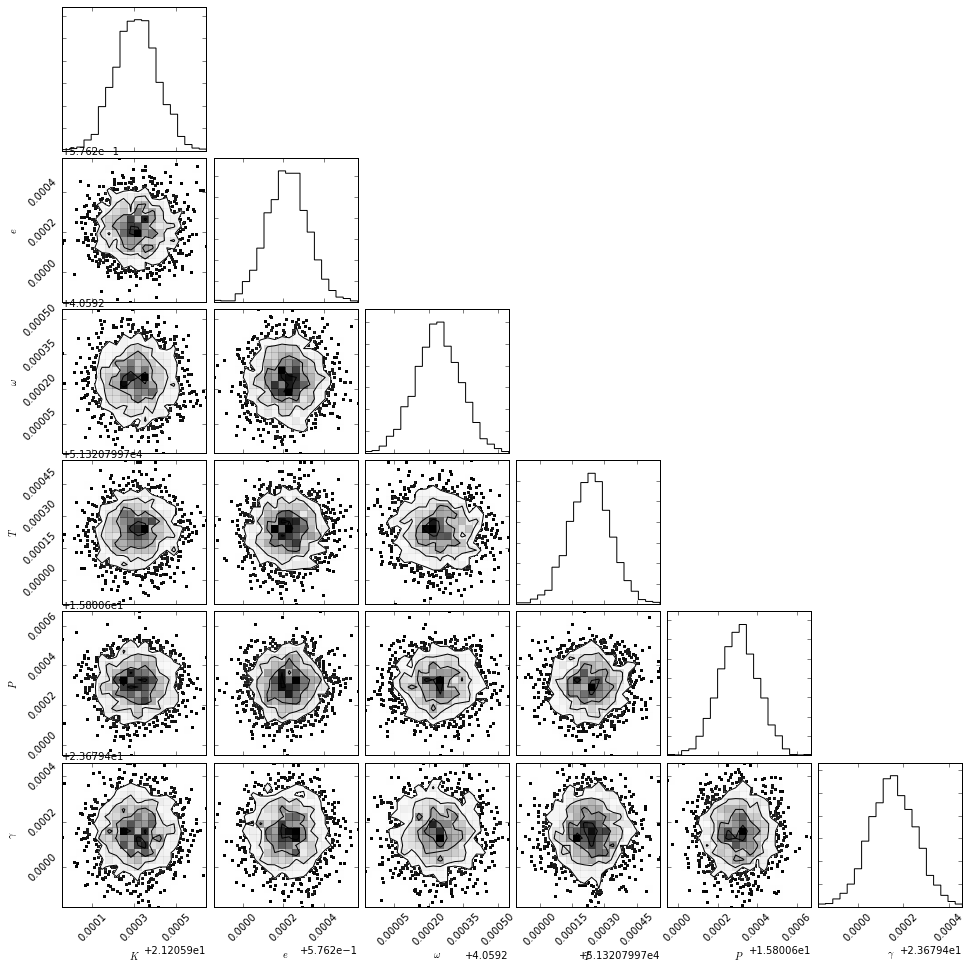

In [71]:
import corner
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$K$", "$e$", "$\omega$", "$T$", "$P$", "$\gamma$"])
#fig.savefig("triangle.png")

(0, 1)

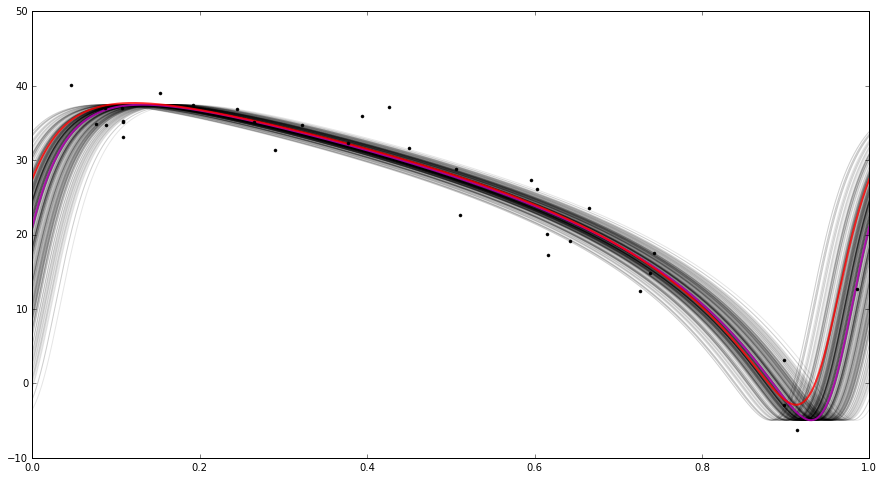

In [72]:
x = np.linspace(0, parameters[4], num=1000)
plt.figure(figsize=(15,8))
for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=300)]:
    parameters = K, e, w, T, P, y
    primary = RV(x, mass_ratio, parameters)[0]
    plt.plot(x/parameters[4], RV(x, mass_ratio, parameters)[0], color="k", alpha=0.1)

plt.plot(x/parameters[4], RV(x, mass_ratio, initial_guess)[0], color="m", lw=2, alpha=0.8) #initial guess curve

primary = RV(x, mass_ratio, [20.28, 0.568, 4.047, 47433.507, 15.800905, 24.52])[0] 
plt.plot(x/15.800905, primary, color="r", lw=2, alpha=0.8) #Czekala et al. result

plt.plot(phases(15.800905, 0, JDp), RVp, 'k.') #data phased to initial guess period
plt.xlim(0,1)

#I'm curious why the semiamplitude doesn't seem to be changing much during the MCMC process